# shift function test

In [1]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube
from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from   scipy.stats import lognorm
import torch.special as S

from dataset import Vibrate

In [2]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data).to(torch.float32)
    data = data.unsqueeze(0)
    return data

In [3]:
data = make_ball(r=20, datasize=[240, 128, 128])
nd_data = data.detach().numpy().copy()

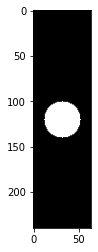

In [4]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [5]:
class Emission(nn.Module):
    def __init__(self, mu_z, sig_z, log_ez0):
        super().__init__()
        self.mu_z     = mu_z
        self.sig_z    = sig_z
        self.log_ez0  = log_ez0
        #self.mu_z_    = mu_z.item()
        #self.sig_z_   = sig_z.item()
        #self.logn_ppf = lognorm.ppf([0.99], 1,
        #                    loc=self.mu_z_, scale=self.sig_z_)[0]
        
    def sample(self, x):
        b = x.shape[0]
        pz0  = dist.LogNormal(loc   = self.mu_z.view( b, 1, 1, 1, 1).expand(*x.shape),
                              scale = self.sig_z.view(b, 1, 1, 1, 1).expand(*x.shape),)
        x    = x * pz0.sample().to(x.device)
        x    = torch.clip(x, min=0, max=1)
        #x    = x / self.logn_ppf
        return x

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        return x


class Intensity(nn.Module):
    def __init__(self, gamma, image_size, initial_depth, voxel_size, scale,
                 device):
        super().__init__()
        init_d = initial_depth
        im_z,  \
        im_x,  \
        im_y   = image_size
        end_d  = im_z * voxel_size * scale
        depth  = init_d \
               + torch.linspace(0, end_d, im_z,).view(-1,1,1,).to(device)
        _intensity = torch.exp(-2 * depth * gamma) # gamma = 0.005
        self._intensity = _intensity.expand(image_size)

    def forward(self, x):
         x = x * self.intensity
         return x

    @property
    def intensity(self):
        return self._intensity


class Blur(nn.Module):
    def __init__(self, z, x, y, log_bet_z, log_bet_xy, log_k, log_l, scale, device,
                 psf_mode:str="double_exp", apply_hill=False):
        super().__init__()
        self.log_bet_z   = log_bet_z
        self.log_bet_xy  = log_bet_xy
        self.log_k   = log_k
        self.log_l   = log_l
        self.zscale, \
        self.xscale, \
        self.yscale  = scale
        self.z       = z
        self.x       = x
        self.y       = y
        self.device  = device
        self.zd      = self.distance(z)
        self.dp      = self.gen_distance_plane(xlen=x, ylen=y)
        self.mode    = psf_mode
        bet_xy       = torch.exp(self.log_bet_xy)
        bet_z        = torch.exp(self.log_bet_z )
        k        = torch.exp(self.log_k )
        self.psf     = self.gen_psf(bet_xy, bet_z, k).to(device)
        self.z_pad   = (z - self.zscale + 1) // 2
        self.x_pad   = (x - self.xscale + 1) // 2
        self.y_pad   = (y - self.yscale + 1) // 2
        self.stride  = (self.zscale, self.xscale, self.yscale)
        self.apply_hill = apply_hill

    def forward(self, x):
        x_shape = x.shape
        bet_xy  = torch.exp(self.log_bet_xy)
        bet_z   = torch.exp(self.log_bet_z )
        k   = torch.exp(self.log_k )
        psf = self.gen_psf(bet_xy, bet_z, k).to(self.device)
        _x   = F.conv3d(input   = x                                    ,
                        weight  = psf                                  ,
                        stride  = self.stride                          ,
                        padding = (self.z_pad, self.x_pad, self.y_pad,),)
        batch = _x.shape[0]
        x = torch.empty(size=(*x_shape[:2], *_x.shape[2:])).to(self.device)
        for b in range(batch):
                x[b, 0] = _x[b, b]
        if self.apply_hill:
            log_x = torch.log(x + 1e-8)
            log_l_x_k = torch.exp(self.log_k) * (self.log_l - log_x) #k = 0.5
            l_x_k = torch.exp(log_l_x_k)
            denom = torch.log(1. + l_x_k)
            x = torch.exp( - denom)
        return x

    def gen_psf(self, bet_xy, bet_z, k):
        if bet_xy.shape:
            b = bet_xy.shape[0]
        else:
            b = 1
        if self.mode == "student_t":
            psf_lateral = self.gen_2dstudent_t(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dstudent_t(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
        if self.mode == "gumbel":
            psf_lateral = self.gen_2dgumbel(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dgumbel(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
            if not k.shape:
                k = k.unsqueeze(0)
            psf = self.gen_double_exp_dist(psf, k[:, None, None, None, None],)
        if self.mode == "weibull":
            psf_lateral = self.gen_2dweibull(self.dp, bet_xy, b, k)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dweibull(self.zd, bet_z , b, k)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
        if self.mode == "gaussian":
            psf_lateral = self.gen_2dnorm(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dnorm(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial)) # log-sum-exp technique
        if self.mode == "double_exp":
            psf_lateral = self.gen_2dnorm(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dnorm(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
            if not k.shape:
                k = k.unsqueeze(0)
            psf = self.gen_double_exp_dist(psf, k[:, None, None, None, None],)
        psf = psf / torch.sum(psf)
        return psf

    def _init_distance(self, length):
        return torch.zeros(length)

    def _distance_from_center(self, index, length):
        return abs(index - length // 2)

    def distance(self, length):
        distance = torch.zeros(length)
        for idx in range(length):
            distance[idx] = self._distance_from_center(idx, length)
        return distance.to(self.device)

    def gen_distance_plane(self, xlen, ylen):
        xd = self.distance(xlen)
        yd = self.distance(ylen)
        xp = xd.expand(ylen, xlen)
        yp = yd.expand(xlen, ylen).transpose(1, 0)
        dp = xp ** 2 + yp ** 2
        return dp.to(self.device)

    def gen_2dnorm(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane / bet_xy ** 2
        normterm = (torch.pi * 2) * (bet_xy ** 2)
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

    def gen_1dnorm(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance ** 2 / bet_z ** 2
        normterm = (torch.pi * 2) ** 0.5 * bet_z
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm
    
    def gen_2dgumbel(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane**0.5 / bet_xy
        norm     = torch.exp(-d_2)
        return norm

    def gen_1dgumbel(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance / bet_z
        norm     = torch.exp(-d_2)
        return norm
    ##
    def gen_2dweibull(self, distance_plane, bet_xy, b, k):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane**0.5 / bet_xy
        norm     = - d_2 ** k
        return norm
    ##
    def gen_1dweibull(self, distance, bet_z, b, k):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance / bet_z
        norm     = - d_2 ** k
        return norm

    def gen_2dstudent_t(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  (distance_plane / bet_xy + 1) ** -((bet_xy + 1) / 2)
        normterm = torch.exp(S.gammaln((bet_xy + 1) / 2) - S.gammaln(bet_xy / 2)) / (torch.pi * bet_xy) ** 0.5
        norm     = normterm * d_2 
        return norm

    def gen_1dstudent_t(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  (distance ** 2 / bet_z + 1) ** -((bet_z + 1) / 2)
        normterm = torch.exp(S.gammaln((bet_z + 1) / 2) - S.gammaln(bet_z / 2)) / (torch.pi * bet_z) ** 0.5
        norm     = normterm * d_2 
        return norm

    def gen_double_exp_dist(self, norm, k,):
        pdf  = 1. - torch.exp(-k * norm)
        return pdf


class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        return x
    
    def sample(self, x):
        b = x.shape[0]
        px = dist.Normal(loc   = x           ,
                         scale = self.sig_eps.view(b, 1, 1, 1, 1).expand(*x.shape).to(x.device))
        x  = px.rsample()
        x  = torch.clip(x, min=0, max=1)
        return x


class PreProcess(nn.Module):
    def __init__(self, min, max):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        x = torch.clip(x, min=self.min, max=self.max)
        x = (x - self.min) / (self.max - self.min)
        return x


class ImagingProcess(nn.Module):
    def __init__(self, device, params,
                 z, x, y, postmin=0., postmax=1.,
                 mode:str="train",dist="double_exp", apply_hill=False):
        super().__init__()
        self.device = device
        self.z = z
        self.x = x
        self.y = y
        self.postmin = postmin
        self.postmax = postmax
        if mode == "train":
            self.mu_z   = torch.tensor(params["mu_z"])
            self.sig_z  = torch.tensor(params["sig_z"])
            self.log_ez0 = nn.Parameter((torch.tensor(params["mu_z"] + 0.5 * params["sig_z"] ** 2)).to(device), requires_grad=True)
            self.log_bet_z  = nn.Parameter(torch.tensor(params["log_bet_z" ]).to(device), requires_grad=True)
            self.log_bet_xy = nn.Parameter(torch.tensor(params["log_bet_xy"]).to(device), requires_grad=True)
            self.log_k  = nn.Parameter(torch.tensor(params["log_k" ]).to(device), requires_grad=True)
            self.log_l  = nn.Parameter(torch.tensor(params["log_l" ]).to(device), requires_grad=True)
        elif mode == "dataset":
            self.mu_z    = nn.Parameter(torch.tensor(params["mu_z"  ]), requires_grad=False)
            self.sig_z   = nn.Parameter(torch.tensor(params["sig_z" ]), requires_grad=False)
            self.log_bet_z   = nn.Parameter(torch.tensor(params["log_bet_z" ]), requires_grad=False)
            self.log_bet_xy  = nn.Parameter(torch.tensor(params["log_bet_xy"]), requires_grad=False)
            self.log_k   = nn.Parameter(torch.tensor(params["log_k" ]), requires_grad=False)
            self.log_l   = nn.Parameter(torch.tensor(params["log_l" ]), requires_grad=False)
        else:
            raise(NotImplementedError())
        scale = [params["scale"], 1, 1]
        self.emission   = Emission(mu_z    = self.mu_z ,
                                   sig_z   = self.sig_z,
                                   log_ez0 = self.log_ez0,)
        self.blur       = Blur(z           = z              ,
                               x           = x              ,
                               y           = y              ,
                               log_bet_z   = self.log_bet_z ,
                               log_bet_xy  = self.log_bet_xy,
                               log_k       = self.log_k     ,
                               log_l       = self.log_l     ,
                               scale       = scale          ,
                               device      = device         ,
                               psf_mode    = dist           ,
                               apply_hill  = apply_hill     ,)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=postmin, max=postmax)

    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = self.preprocess(x)
        return x

    def sample(self, x):
        x = self.emission.sample(x)
        x = self.blur(x)
        x = self.noise.sample(x)
        x = self.preprocess(x)
        return x
    
    def sample_from_params(self, x, params):
        if isinstance(params["scale"], torch.Tensor):
            z = int(params["scale"][0])
        else:
            z = params["scale"]
        scale = [z, 1, 1] ## use only one scale
        emission   = Emission(tt(params["mu_z"]), tt(params["sig_z"]))
        blur       = Blur(self.z, self.x, self.y,
                          tt(params["log_bet_z"]), tt(params["log_bet_xy"]),
                          tt(params["log_k"]), scale, self.device)
        noise      = Noise(tt(params["sig_eps"]))
        preprocess = PreProcess(min=self.postmin, max=self.postmax)
        x = emission.sample(x)
        x = blur(x)
        x = noise.sample(x)
        x = preprocess(x)
        return x

In [6]:
dirpath = "_beads_roi_extracted"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
beadslist
label = torch.load(beadslist[0], map_location="cuda").to(torch.float32)

In [7]:
loss_fn = nn.MSELoss()

def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = loss_fn(x, label)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if _ % 10 == 0:
            print(f'epoch {_}, loss {loss:.8f}', model.state_dict())
    return loss.item()

In [8]:
import torch
torch.__version__

'1.13.1+cu117'

# gaussian
## no clip, no hill

torch.Size([1, 240, 128, 128])


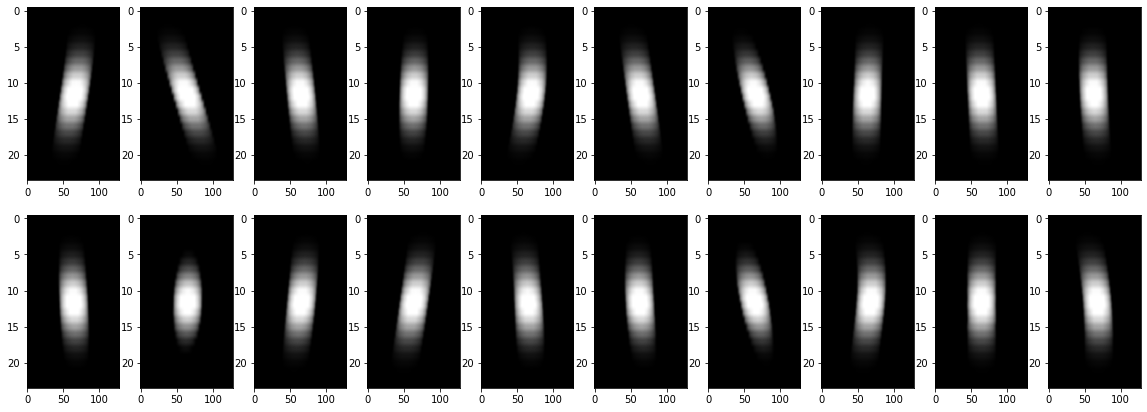

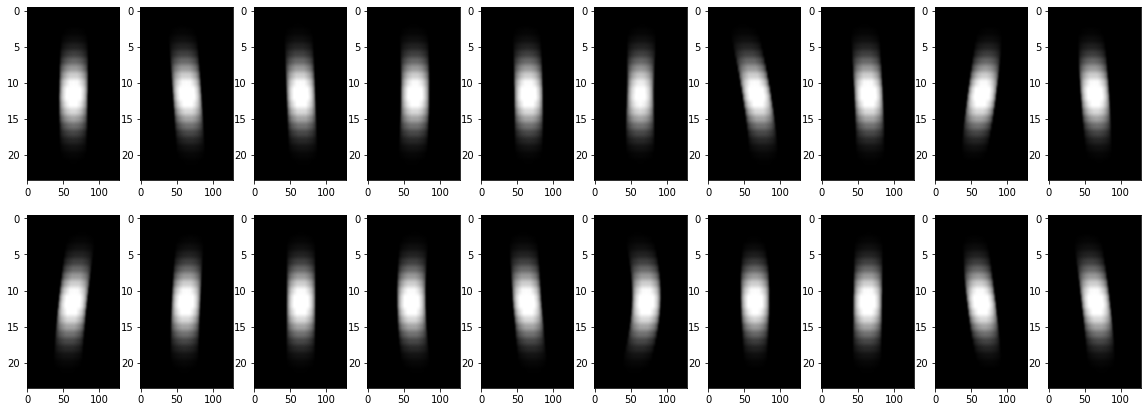

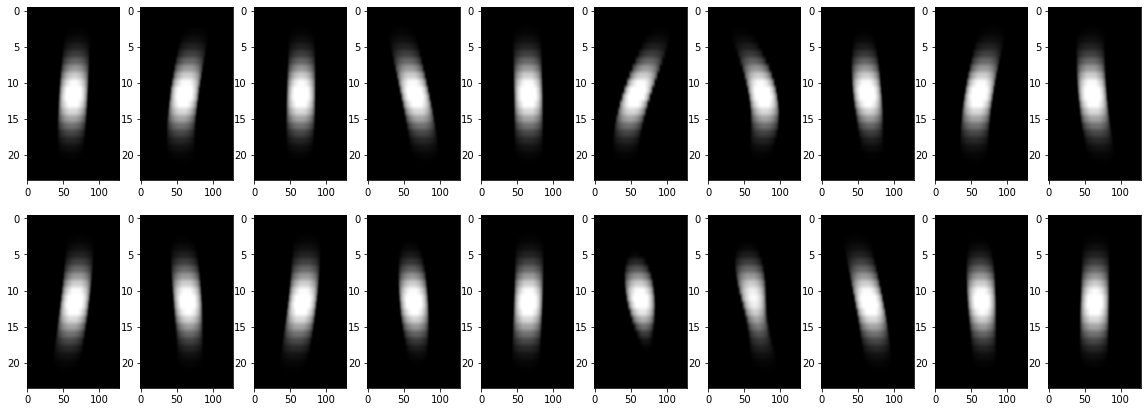

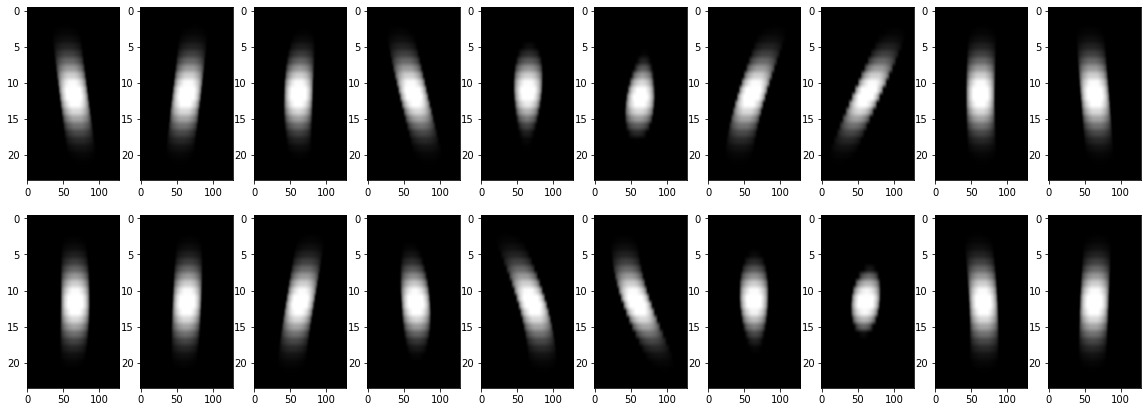

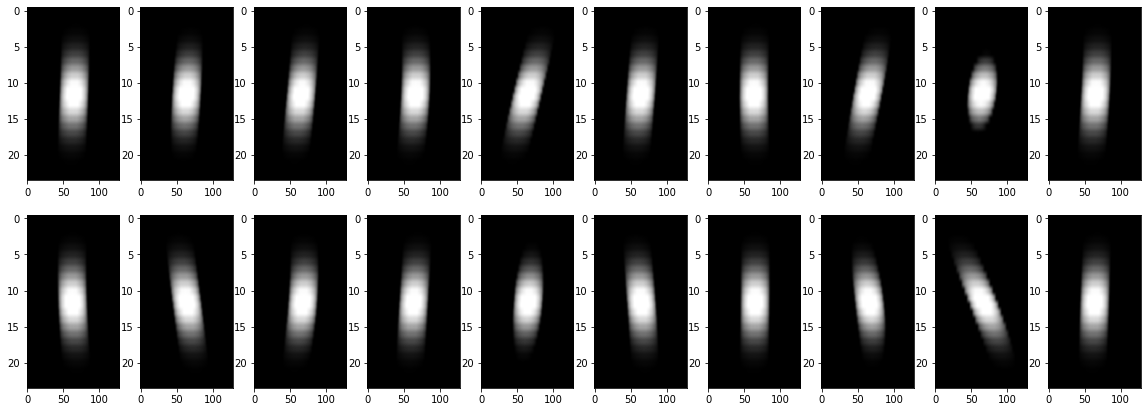

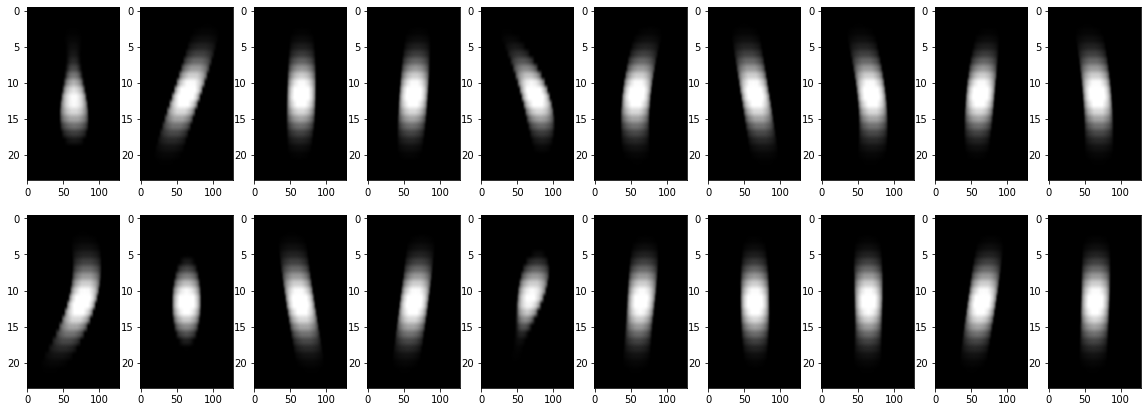

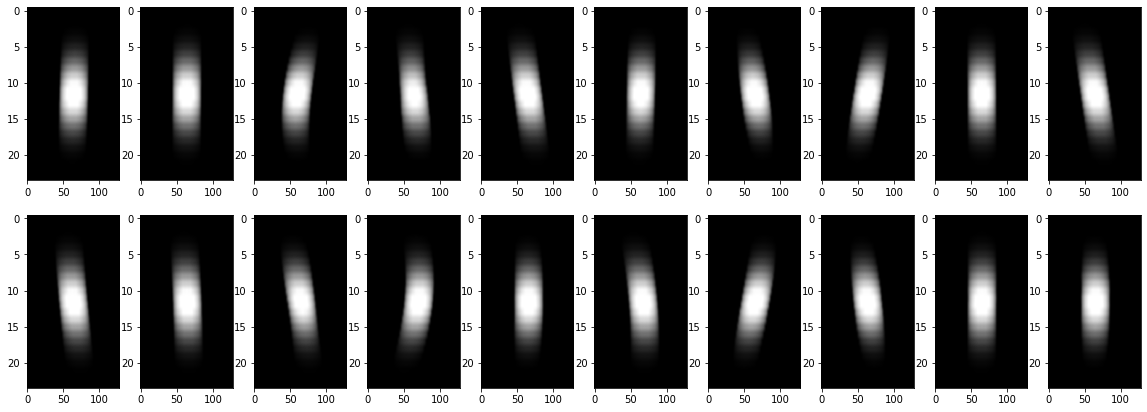

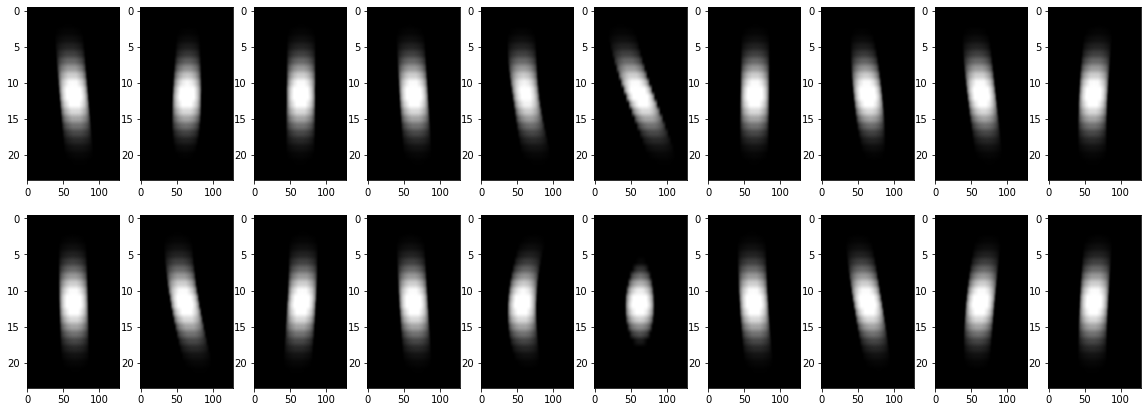

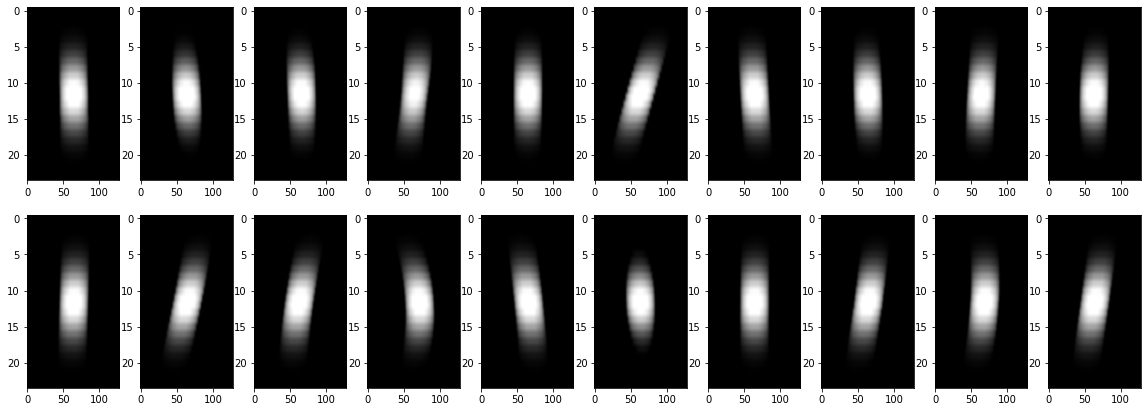

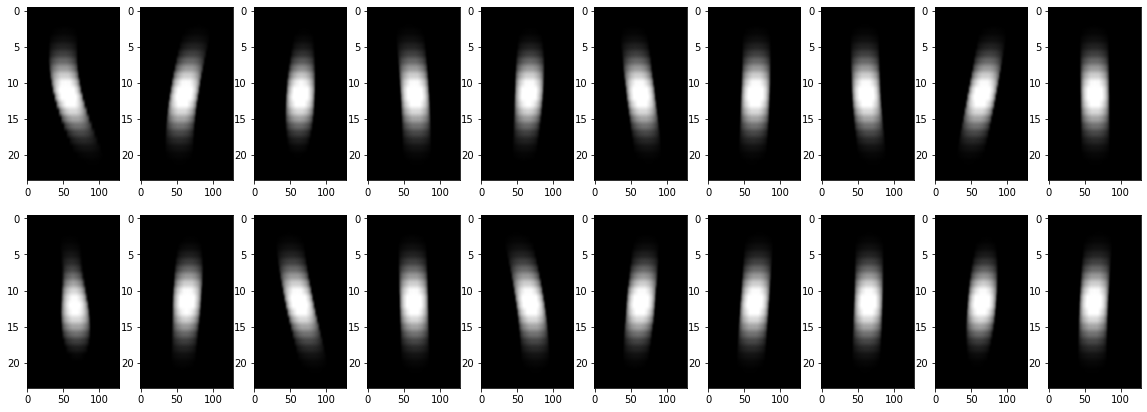

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
print(obj.shape)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3

params = {"mu_z"       : 0.83 ,
          "sig_z"      : 0.    ,
          "log_bet_z"  : 3.4109 ,
          "log_bet_xy" : 0.8015 ,
          "log_k"      : np.log(1.).item(),
          "log_l"      : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
cols = 10
for _ in range(10):    
    fig, ax = plt.subplots(nrows = 2, ncols=cols, figsize=(20, 7))
    v = Vibrate()
    for i in range(cols):
        blu = ImagingProcess(device       = device           ,
                              params       = params           ,
                              z            = z                ,
                              x            = x                ,
                              y            = y                ,
                              mode         = "train"          ,
                              dist         = "gaussian"       ,
                              apply_hill   = False            ,
                              )
        t = data.to(device).unsqueeze(0)
        t = blu(t).squeeze(0)
        t = v(t)
        t = t.detach().to('cpu')
        x_img = t[0, :, 64, :]
        y_img = t[0, :, :, 64]
        ax[0, i].imshow(x_img, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[1, i].imshow(y_img, aspect=10, vmin=0, vmax=1,cmap='gray')
    plt.show()

# gaussian + hill
## no clip

beads_001_roi000
epoch 0, loss 0.00354122 OrderedDict([('log_ez0', tensor(0.2300, device='cuda:0')), ('log_bet_z', tensor(2.9857, device='cuda:0')), ('log_bet_xy', tensor(0.0100, device='cuda:0')), ('log_k', tensor(-0.0100, device='cuda:0')), ('log_l', tensor(-0.0100, device='cuda:0')), ('emission.log_ez0', tensor(0.2300, device='cuda:0')), ('blur.log_bet_z', tensor(2.9857, device='cuda:0')), ('blur.log_bet_xy', tensor(0.0100, device='cuda:0')), ('blur.log_k', tensor(-0.0100, device='cuda:0')), ('blur.log_l', tensor(-0.0100, device='cuda:0'))])
epoch 10, loss 0.00290740 OrderedDict([('log_ez0', tensor(0.3290, device='cuda:0')), ('log_bet_z', tensor(3.0008, device='cuda:0')), ('log_bet_xy', tensor(0.1113, device='cuda:0')), ('log_k', tensor(-0.1084, device='cuda:0')), ('log_l', tensor(-0.1090, device='cuda:0')), ('emission.log_ez0', tensor(0.3290, device='cuda:0')), ('blur.log_bet_z', tensor(3.0008, device='cuda:0')), ('blur.log_bet_xy', tensor(0.1113, device='cuda:0')), ('blur.log_k', 

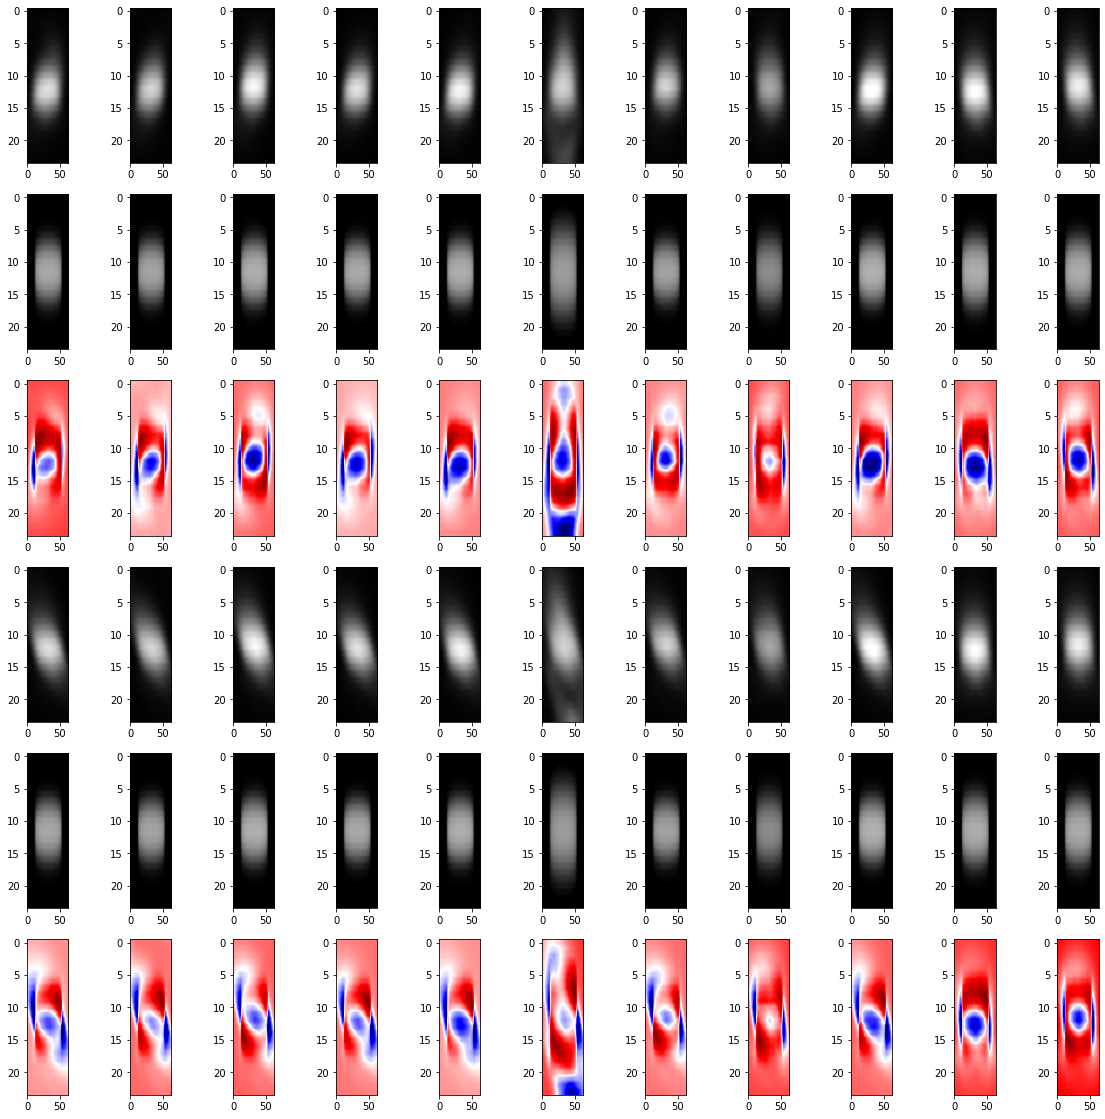

[0.001865695114247501,
 0.0076217567548155785,
 0.005930665880441666,
 0.0016202362021431327,
 0.0019942023791372776,
 0.0032257135026156902,
 0.001246744068339467,
 0.000725895632058382,
 0.0026462594978511333,
 0.001748500159010291,
 0.0011209000367671251]

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_k"  : np.log(1.).item(),
          "log_l"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
fig, ax = plt.subplots(nrows = 6, ncols=len(beadslist), figsize=(20, 20))
for i, bead in enumerate(beadslist):
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gaussian"       ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    label = label.detach().to("cpu")
    x_label = label[0, :, 64, 32:96]
    y_label = label[0, :, 32:96, 64]
    t = data.to(device).unsqueeze(0)
    t = blur(t).squeeze(0)
    t = t.detach().to('cpu')
    x_img = t[0, :, 64, 32:96]
    y_img = t[0, :, 32:96, 64]
    ax[0, i].imshow(x_label, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[1, i].imshow(x_img, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[2, i].imshow((x_img - x_label + 1) / 2, aspect=10, cmap='seismic')
    ax[3, i].imshow(y_label, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[4, i].imshow(y_img, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[5, i].imshow((y_img - y_label + 1) / 2, aspect=10, cmap='seismic')
    losses.append(loss)
plt.show()
losses

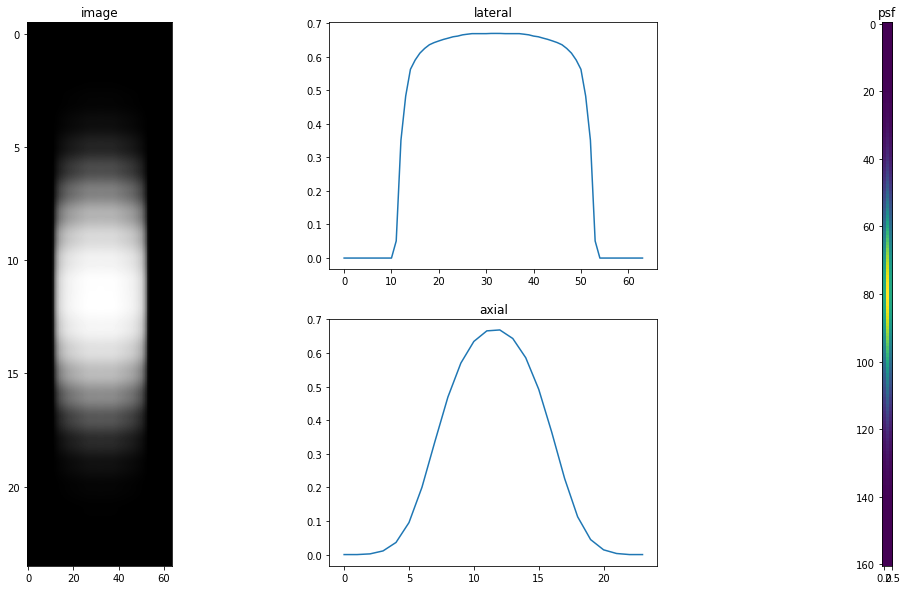

In [36]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# gaussian + hill
## clip

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_k"  : np.log(1.).item(),
          "log_l"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gaussian"       ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
        label = label.detach().to("cpu")
    x_label = label[0, :, 64, 32:96]
    y_label = label[0, :, 32:96, 64]
    t = data.to(device).unsqueeze(0)
    t = blur(t).squeeze(0)
    t = t.detach().to('cpu')
    x_img = t[0, :, 64, 32:96]
    y_img = t[0, :, 32:96, 64]
    ax[0, i].imshow(x_label, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[1, i].imshow(x_img, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[2, i].imshow((x_img - x_label + 1) / 2, aspect=10, cmap='cool')
    ax[3, i].imshow(y_label, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[4, i].imshow(y_img, aspect=10, vmin=0, vmax=1,cmap='gray')
    ax[5, i].imshow((y_img - y_label + 1) / 2, aspect=10, cmap='cool')
    losses.append(loss)
plt.show()
losses

beads_001_roi000
epoch 0, loss 0.00191077 OrderedDict([('log_ez0', tensor(0.2300, device='cuda:0')), ('log_bet_z', tensor(2.9857, device='cuda:0')), ('log_bet_xy', tensor(0.0100, device='cuda:0')), ('log_k', tensor(-0.0100, device='cuda:0')), ('log_l', tensor(-0.0100, device='cuda:0')), ('emission.log_ez0', tensor(0.2300, device='cuda:0')), ('blur.log_bet_z', tensor(2.9857, device='cuda:0')), ('blur.log_bet_xy', tensor(0.0100, device='cuda:0')), ('blur.log_k', tensor(-0.0100, device='cuda:0')), ('blur.log_l', tensor(-0.0100, device='cuda:0'))])
epoch 10, loss 0.00145555 OrderedDict([('log_ez0', tensor(0.3283, device='cuda:0')), ('log_bet_z', tensor(2.8902, device='cuda:0')), ('log_bet_xy', tensor(0.1113, device='cuda:0')), ('log_k', tensor(-0.1069, device='cuda:0')), ('log_l', tensor(-0.1083, device='cuda:0')), ('emission.log_ez0', tensor(0.3283, device='cuda:0')), ('blur.log_bet_z', tensor(2.8902, device='cuda:0')), ('blur.log_bet_xy', tensor(0.1113, device='cuda:0')), ('blur.log_k', 

[0.0009772481862455606,
 0.005656735505908728,
 0.003948814235627651,
 0.0008747290121391416,
 0.0011874893680214882,
 0.0013604358537122607,
 0.00052028673235327,
 0.00021210573322605342,
 0.001424139365553856,
 0.0009559394675306976,
 0.0004202231648378074]

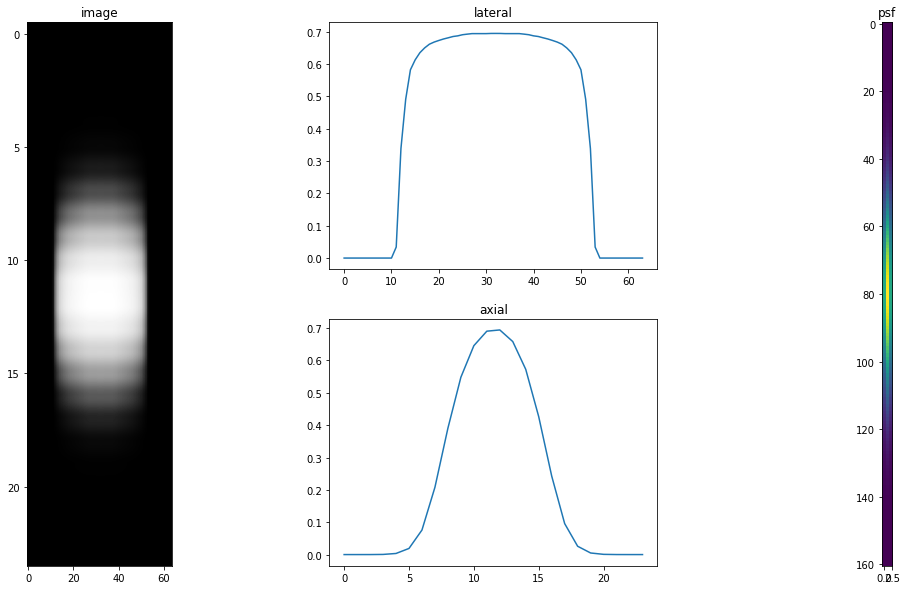

In [38]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# student_t with hill
## no clip

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_k"      : np.log(1.).item(),
          "log_l"      : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    #label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "student_t"      ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00506380 OrderedDict([('log_ez0', tensor(0.2300, device='cuda:0')), ('log_bet_z', tensor(2.9858, device='cuda:0')), ('log_bet_xy', tensor(0.0099, device='cuda:0')), ('log_k', tensor(-0.0100, device='cuda:0')), ('log_l', tensor(-0.0100, device='cuda:0')), ('emission.log_ez0', tensor(0.2300, device='cuda:0')), ('blur.log_bet_z', tensor(2.9858, device='cuda:0')), ('blur.log_bet_xy', tensor(0.0099, device='cuda:0')), ('blur.log_k', tensor(-0.0100, device='cuda:0')), ('blur.log_l', tensor(-0.0100, device='cuda:0'))])
epoch 10, loss 0.00492948 OrderedDict([('log_ez0', tensor(0.3281, device='cuda:0')), ('log_bet_z', tensor(2.8843, device='cuda:0')), ('log_bet_xy', tensor(0.1091, device='cuda:0')), ('log_k', tensor(-0.1081, device='cuda:0')), ('log_l', tensor(-0.1081, device='cuda:0')), ('emission.log_ez0', tensor(0.3281, device='cuda:0')), ('blur.log_bet_z', tensor(2.8843, device='cuda:0')), ('blur.log_bet_xy', tensor(0.1091, device='cuda:0')), ('blur.log_k', 

[0.0029359040781855583,
 0.008206978440284729,
 0.00856762658804655,
 0.0027486192993819714,
 0.0038890033029019833,
 0.005470968317240477,
 0.002047032816335559,
 0.0017733946442604065,
 0.006254454609006643,
 0.005336730740964413,
 0.003234510775655508]

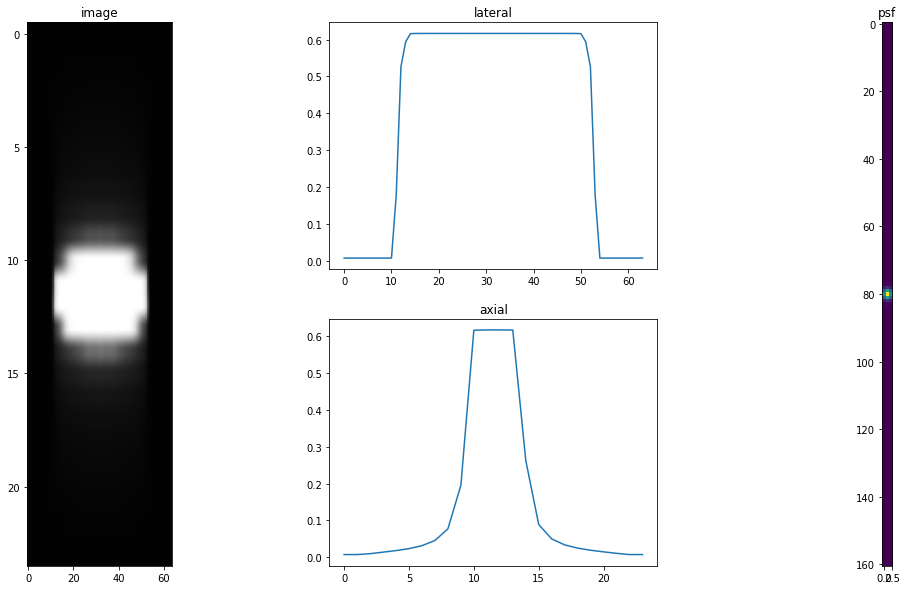

In [40]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# student_t hill
## clipped

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_k"      : np.log(1.).item(),
          "log_l"      : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "student_t"      ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00304748 OrderedDict([('log_ez0', tensor(0.2300, device='cuda:0')), ('log_bet_z', tensor(2.9858, device='cuda:0')), ('log_bet_xy', tensor(0.0099, device='cuda:0')), ('log_k', tensor(-0.0100, device='cuda:0')), ('log_l', tensor(-0.0100, device='cuda:0')), ('emission.log_ez0', tensor(0.2300, device='cuda:0')), ('blur.log_bet_z', tensor(2.9858, device='cuda:0')), ('blur.log_bet_xy', tensor(0.0099, device='cuda:0')), ('blur.log_k', tensor(-0.0100, device='cuda:0')), ('blur.log_l', tensor(-0.0100, device='cuda:0'))])
epoch 10, loss 0.00295113 OrderedDict([('log_ez0', tensor(0.3274, device='cuda:0')), ('log_bet_z', tensor(2.8844, device='cuda:0')), ('log_bet_xy', tensor(0.1088, device='cuda:0')), ('log_k', tensor(-0.1089, device='cuda:0')), ('log_l', tensor(-0.1074, device='cuda:0')), ('emission.log_ez0', tensor(0.3274, device='cuda:0')), ('blur.log_bet_z', tensor(2.8844, device='cuda:0')), ('blur.log_bet_xy', tensor(0.1088, device='cuda:0')), ('blur.log_k', 

[0.0017402147641405463,
 0.006195630878210068,
 0.005447819828987122,
 0.0016548761632293463,
 0.0024021619465202093,
 0.0028295405209064484,
 0.0011139458511024714,
 0.0009058155119419098,
 0.003935001790523529,
 0.003188088070601225,
 0.0017288061790168285]

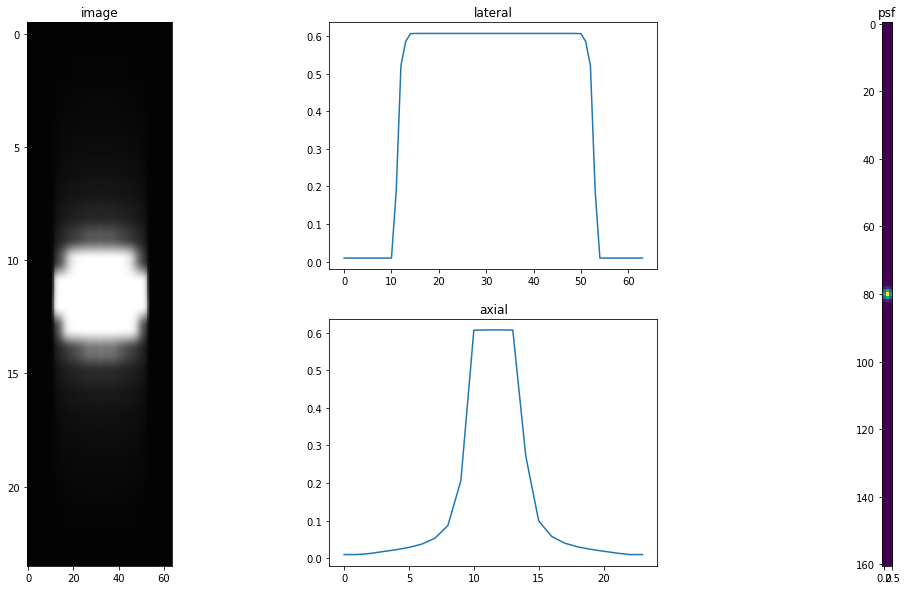

In [42]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()